In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
#to get rid of warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
#-------------data preprocessing------------------------

#import data set
train_data = pd.read_csv("cs-training.csv")    
test_data = pd.read_csv("cs-test.csv")

In [28]:
#see information of the sataframe
train_data.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,NaN,5.000000,0.000000,0.000000,0.000000,NaN
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,NaN,8.000000,0.000000,1.000000,0.000000,NaN
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,NaN,11.000000,0.000000,2.000000,0.000000,NaN
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


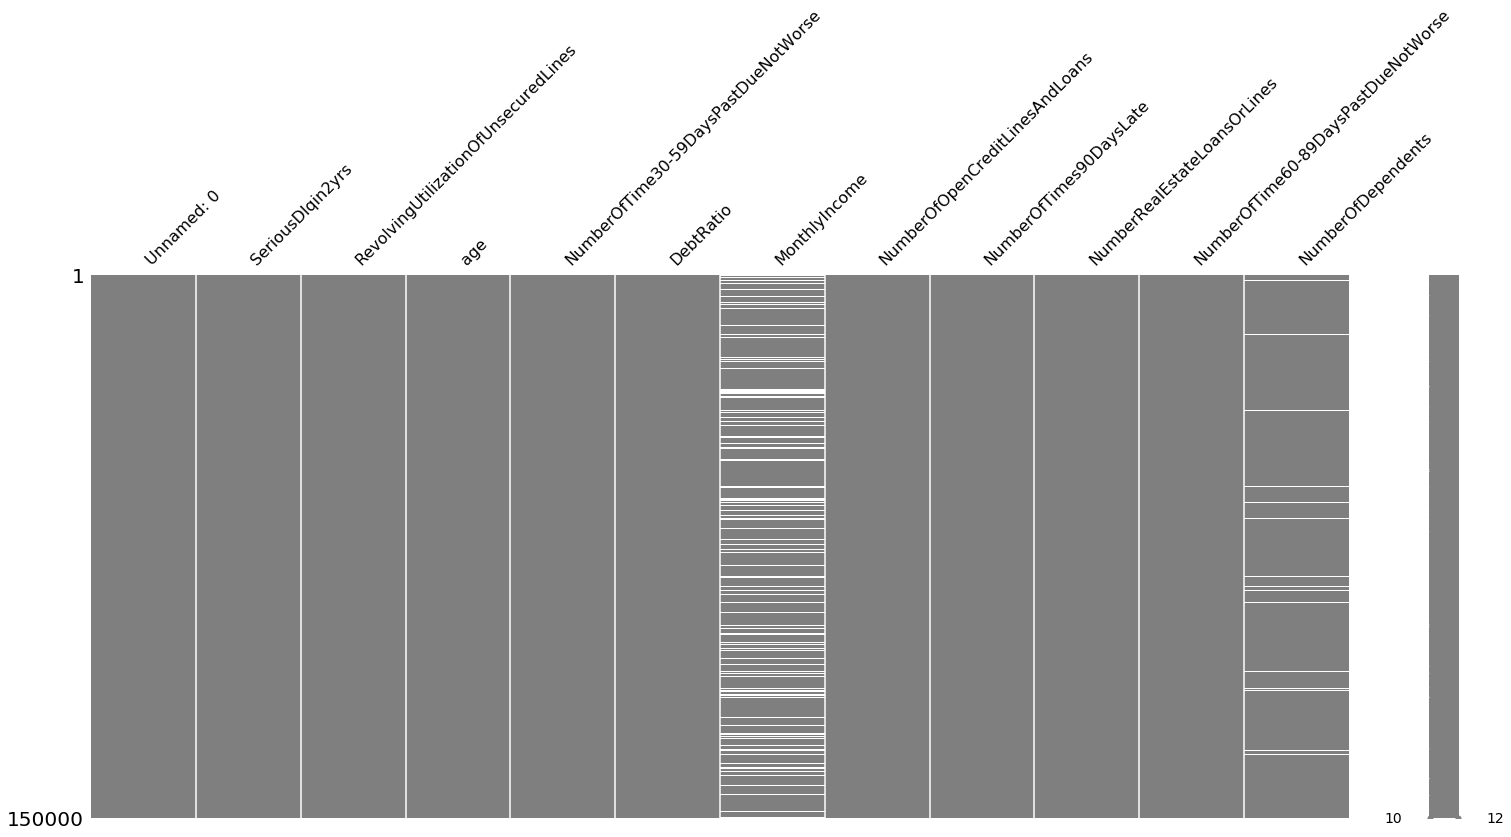

In [29]:
#check null values
train_data.isnull().values.any() 
missingno.matrix(train_data, color = (0.5, 0.5, 0.5))

In [30]:
#fill all the null
def income_rf(df):           #use random forest to fill null in 'Monthly Income' 
    data = df
    df = df.iloc[:,[6,2,3,4,5,7,8,9,10,11]]
    known = df[df.MonthlyIncome.notnull()].as_matrix()   #set not null in monthly income as train
    unknown = df[df.MonthlyIncome.isnull()].as_matrix()  #set null in monthly income as test
    
    #train_X
    X = known[:,1:]
    #train_Y
    y = known[:,0]
    #train
    rf = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1) #use rf to fill null
    rf.fit(X,y)
    #predict
    pred = rf.predict( unknown[:,1:]).round(0)
    #fill
    df.loc[df['MonthlyIncome'].isnull(),'MonthlyIncome'] = pred
    df = df.iloc[:,[1,2,3,4,0,5,6,7,8,9]] 
    frames = [data[[1]], df]               #combine test &train data
    result = pd.concat(frames,axis=1)
    return result


def data_clean(df):
    #make all age below 19 median
    df.loc[train_data["age"] <= 18, "age"] = df.age.median()
    
    #fill NumberOfDependents null with median
    df["NumberOfDependents"] = df["NumberOfDependents"].fillna(df.NumberOfDependents.median())
    df["NumberOfDependents"] = df["NumberOfDependents"].astype('int64')
    
    #split dataframe into two dataframe by age interval
    age_1 = df.loc[(df["age"] > 25) & (df["age"] < 70)]    #age between 25 and 70
    age_2 = df.loc[(df["age"] >= 70) | (df["age"] <= 25)]  #age under 25 or over 70
    
    #use rf function to fill null
    age_1 = income_rf(age_1)
    age_2 = income_rf(age_2)
    
    frames = [age_1, age_2]
    result = pd.concat(frames)    #cobine two dataframe

    return result

In [31]:
#use clean function to clean both test and train dataframe
test_data =  data_clean(test_data)
train_data = data_clean(train_data)

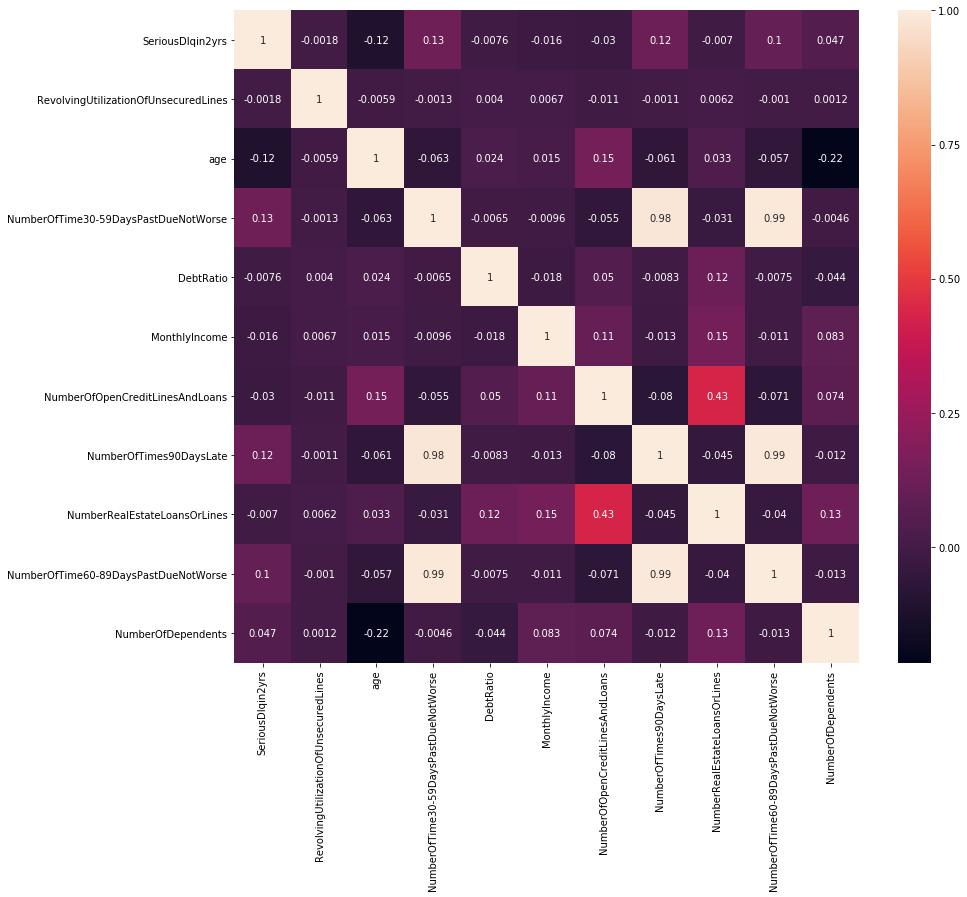

In [7]:
#check data correlation
corr = train_data.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

In [32]:
#drop two of the three highly correlated column, to avoid Multicollinearity
train_data.drop(["NumberOfTimes90DaysLate","NumberOfTime60-89DaysPastDueNotWorse"], axis=1, inplace=True)
test_data.drop(["NumberOfTimes90DaysLate","NumberOfTime60-89DaysPastDueNotWorse"], axis=1, inplace=True)

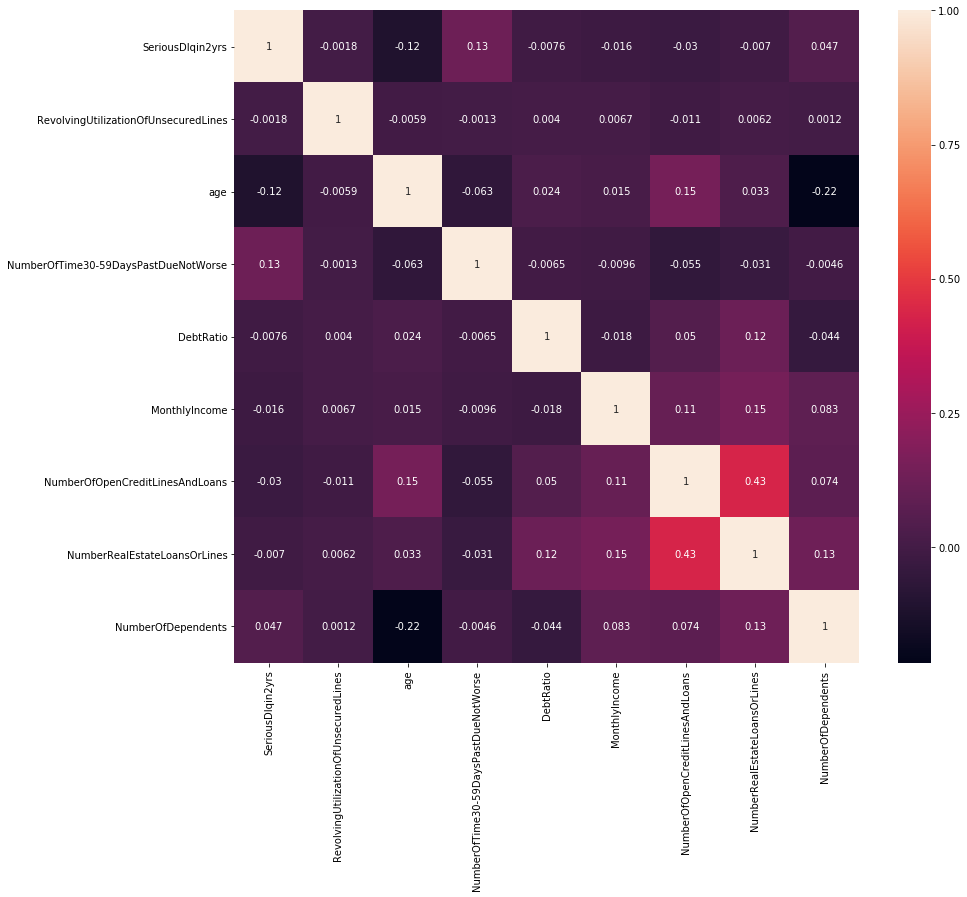

In [9]:
#check data correlation again
corr = train_data.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

In [33]:
#use random under sampler to avoid undersampling
rus = RandomUnderSampler(random_state=0)

train_X = train_data.iloc[:,1:]
train_Y = train_data.iloc[:,0:1]

X_resampled, y_resampled = rus.fit_sample(train_X, train_Y)

X_resampled = pd.DataFrame(data = X_resampled)   #from array to dataframe
y_resampled = pd.DataFrame(data = y_resampled)

In [11]:
#-----------using training data to test classifier 
target = y_resampled
features = X_resampled
# 80%train,20%test
train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.20, stratify = target, random_state = 1)

In [16]:
#use pipeline and gridsearch to find the best classifier and parameter based on roc_auc score

from sklearn.ensemble import GradientBoostingClassifier

classifier = [
        #LogisticRegression(random_state = 1, max_iter=500),
        #DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
        #RandomForestClassifier(random_state = 1, criterion = 'gini',max_depth = 5),
        #KNeighborsClassifier(metric = 'minkowski'),
        GradientBoostingClassifier(random_state = 1),
        ]

classifier_names = [
        #'logisticregression',
        #'decisiontreeclassifier',
        #'randomforestclassifier',
        #'kneighborsclassifier',
        'gradientboostingclassifier',
        ]

#parameter
classifier_param_grid = [
        #{'logisticregression__C':[100,200,300,50,20,600]},
        #{'decisiontreeclassifier__max_depth':[4,6,8,10]},
        #{'randomforestclassifier__n_estimators':[10,50,100,400],'randomforestclassifier__max_depth':[5,7,9,11],'randomforestclassifier__min_samples_split':[0.1,0.05,0.01],'randomforestclassifier__min_samples_leaf':[0.1,0.3,0.5,],'randomforestclassifier__max_features':[4,5,6,7,8]} ,
        #{'kneighborsclassifier__n_neighbors':[6,8,10,12]},
        {'gradientboostingclassifier__max_depth':[3,5,7,9],'gradientboostingclassifier__max_features':[4,5,6,7,8],'gradientboostingclassifier__n_estimators':[10,50,100,300],'gradientboostingclassifier__learning_rate':[0.5,0.25,0.1,0.05,0.01]},
]

 

#use pipeline and gridsearch to find the best classifier and parameter based on roc_auc score
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score = 'accuracy'):
    response = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring='roc_auc')
    # find the best param&accuracy
    search = gridsearch.fit(train_x, train_y)
    print("GridSearch best parameter：", search.best_params_)
    print("GridSearch best score： %0.4lf" %search.best_score_)
    predict_y = gridsearch.predict(test_x)
    print("accuracy %0.4lf" %accuracy_score(test_y, predict_y))
    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy_score(test_y,predict_y)
    return response
   
for model, model_name, model_param_grid in zip(classifier, classifier_names, classifier_param_grid):
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid , score = 'accuracy')

GridSearch best parameter： {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 300, 'gradientboostingclassifier__max_features': 4}
GridSearch best score： 0.8374
accuracy 0.7674


In [14]:
#*********choose random forest  

In [34]:
#train and test set
train_X = X_resampled
train_Y = y_resampled
test_X = test_data.iloc[:,1:]
test_Y = test_data.iloc[:,0:1]

#normalize and standardize your train data
sc = StandardScaler()  
train_X = sc.fit_transform(train_X)  
test_X = sc.transform(test_X)  

In [35]:
model = GradientBoostingClassifier(random_state = 1, learning_rate = 0.05, max_depth =  3, n_estimators = 300)
model.fit(train_X,train_Y)
prediction = model.predict_proba(test_X)
scores = prediction[:,1]

In [36]:
#submission file for kaggle
ids = np.arange(1,101504)
submission = pd.DataFrame( {'Id': ids, 'Probability': scores})
submission.to_csv('submission_credit.csv', index=False)

In [37]:
#see the importance of each feature
print(pd.DataFrame(model.feature_importances_, columns = ['importance']))

   importance
0    0.224916
1    0.135824
2    0.084928
3    0.182523
4    0.155608
5    0.108523
6    0.054945
7    0.052733
